In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [4]:
class_names = info.features['label'].names
n_classes = len(class_names)
dataset_size = info.splits['train'].num_examples

In [5]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

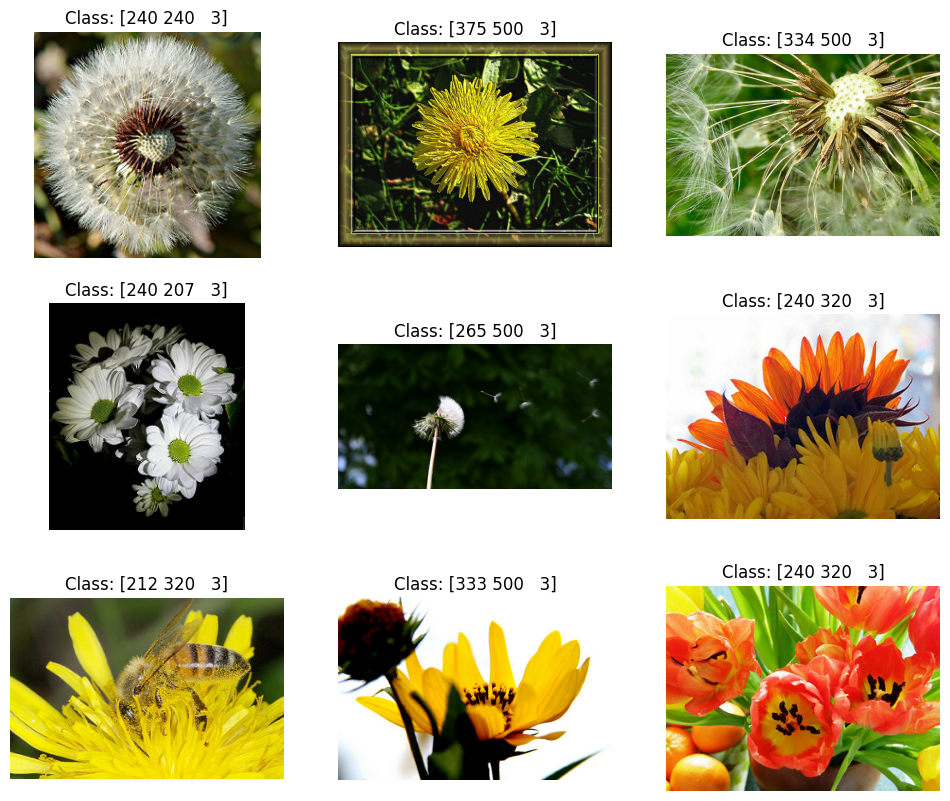

In [8]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(tf.shape(image)))
    plt.axis("off")

plt.show()

In [7]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    print(shape)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Tensor("Shape:0", shape=(3,), dtype=int32)


In [22]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [23]:
for layer in base_model.layers:
        layer.trainable = False

In [30]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 268s 3s/step - loss: 0.6061 - accuracy: 0.8263 - val_loss: 0.5937 - val_accuracy: 0.8272
Epoch 2/5
86/86 [==============================] - 233s 3s/step - loss: 0.3631 - accuracy: 0.8914 - val_loss: 0.6509 - val_accuracy: 0.8603
Epoch 3/5
86/86 [==============================] - 246s 3s/step - loss: 0.3663 - accuracy: 0.9041 - val_loss: 0.7348 - val_accuracy: 0.8493
Epoch 4/5
40/86 [============>.................] - ETA: 1:34 - loss: 0.3059 - accuracy: 0.9148